In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import random

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

In [3]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
x = np.concatenate((train_x, test_x))
y = np.concatenate((train_y, test_y))

In [5]:
print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


In [6]:
train_size = 0.7
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=train_size, random_state=2022,stratify=y)

In [7]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(49000, 28, 28)
(49000,)
(21000, 28, 28)
(21000,)


In [8]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [9]:
train_x = [np.reshape(x, (784, 1)) for x in train_x]
test_x = [np.reshape(x, (784, 1)) for x in test_x]
train_y = [vectorized_result(y) for y in train_y]
test_y = [vectorized_result(y) for y in test_y]

In [10]:
sizes = [784, 100, 10]
num_layers = len(sizes)
biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

In [11]:
def feedforward(a):
        for b, w in zip(biases, weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

In [12]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [13]:
def cost_derivative(output_activations, y):
        return (output_activations-y)

In [14]:
def input_derivative(x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return weights[0].T.dot(delta)

In [15]:
def adversarial(n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

In [21]:
loaded_model = pickle.load(open('simple_network','rb'))

In [44]:
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    a = adversarial(n, 1000, 1)
    x = np.round(feedforward(a), 2)
    temp = tf.expand_dims(np.array([a.reshape(28,28)]),3)
    print(temp.shape)
    prediction = np.argmax(loaded_model.predict(temp))
    
    print('Network Output: \n' + str(x) + '\n')
    
    print( prediction)
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')

In [17]:
def sneaky_adversarial(n, x_target, steps, eta, lam=.05):

    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

In [56]:
def sneaky_generate(n, m):
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while np.argmax(test_y[idx]) != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial( n, test_x[idx], 100, 1)
    x = np.round(feedforward(a), 2)
    temp = tf.expand_dims(np.array([a.reshape(28,28)]),3)
    print(temp.shape)
    prediction = np.argmax(loaded_model.predict(temp))
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_x[idx].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(prediction) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

(1, 28, 28, 1)
Network Output: 
[[1.  ]
 [0.  ]
 [0.17]
 [0.07]
 [0.02]
 [0.05]
 [0.  ]
 [0.07]
 [0.96]
 [0.14]]

10
Adversarial Example: 


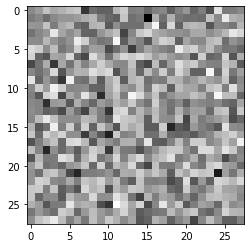

In [54]:
generate(8)

<ipython-input-12-cf67f06c40b7>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


(1, 28, 28, 1)

What we want our adversarial example to look like: 


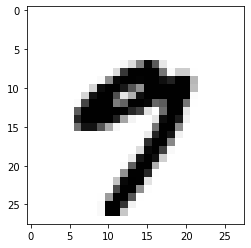



Adversarial Example: 


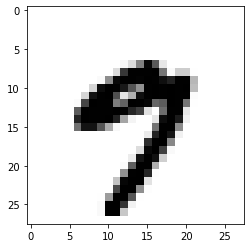

Network Prediction: 9

Network Output: 
[[1.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [1.  ]
 [0.41]
 [0.18]
 [0.99]
 [0.07]
 [0.04]]



array([[-3.92877967e-02],
       [-5.78070104e-02],
       [ 3.06441615e-01],
       [-2.48510463e-03],
       [ 8.74959312e-02],
       [ 3.61765061e-02],
       [-2.55878204e-01],
       [-1.86373871e-01],
       [ 2.75326667e-03],
       [-3.29462034e-01],
       [ 3.91792731e-02],
       [ 1.74696742e-01],
       [ 2.77864024e-02],
       [ 1.23440162e-01],
       [-4.25851619e-02],
       [-1.06538434e-01],
       [-2.02837106e-01],
       [ 3.75674779e-02],
       [-1.53347315e-01],
       [ 1.16257590e-01],
       [ 1.79934081e-01],
       [-9.31544337e-02],
       [ 6.43593072e-02],
       [-3.66422611e-02],
       [ 1.83376078e-01],
       [-2.88397785e-01],
       [ 3.73153761e-03],
       [ 5.94061677e-02],
       [ 1.25675860e-01],
       [-4.88938245e-02],
       [ 4.00300864e-02],
       [ 2.54058309e-03],
       [ 2.88674635e-01],
       [ 7.95988366e-02],
       [-2.67927479e-02],
       [ 8.72033083e-02],
       [-1.19055532e-02],
       [ 5.61813804e-02],
       [-1.3

In [67]:
sneaky_generate(5, 9)